Creates a plot of geopotential height at 500 hPa to confirm the presence of the upper level trough in the reanalysis data. The upper level trough is what 'captures' TC Alby and pushes it towards the SW WA coastline.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import cartopy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

In [349]:
time='1978-04-03T12:00'
plev = 50000.0
latmin,latmax, lonmin,lonmax = -50,-10,85,125

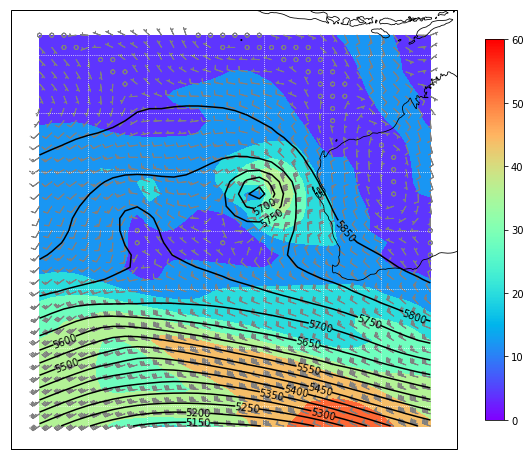

In [358]:
ncfile = 'data/reanalysis/jra55/ncdf/plev/jra55_hgt_anl_p125_19780330_19780405.nc'
hgt = xr.open_dataset(ncfile)
hgt_500 = hgt.sel(plev=plev).var7  #select 500 hPa level
hgt_500 = hgt_500.sel(lat=slice(latmax,latmin), lon=slice(lonmin,lonmax)) #select just the WA/Indian Ocean region
hgt_500_t1 = hgt_500.sel(time=time)
hgt_500_t1 = hgt_500_t1  #GOTTA FIX TIME DIM

ncfile_U = 'data/reanalysis/jra55/ncdf/plev/jra55_ugrd_anl_p125_197803_197804.nc'
U = xr.open_dataset(ncfile_U)
U_500 = U.sel(plev=plev).var33  #select 500 hPa level
U_500 = U_500.sel(lat=slice(latmax,latmin), lon=slice(lonmin,lonmax)) #select just the WA/Indian Ocean region
U_500_t1 = U_500.sel(time=time)

ncfile_V = 'data/reanalysis/jra55/ncdf/plev/jra55_vgrd_anl_p125_197803_197804.nc'
V = xr.open_dataset(ncfile_V)
V_500 = V.sel(plev=plev).var34  #select 500 hPa level
V_500 = V_500.sel(lat=slice(latmax,latmin), lon=slice(lonmin,lonmax)) #select just the WA/Indian Ocean region
V_500_t1 = V_500.sel(time=time)

#calculate windspeed & direction
def wind_uv_to_spd(U,V):
    """
    Calculates the wind speed from the u and v wind components
    """
    WSPD = np.sqrt(np.square(U)+np.square(V))
    return WSPD

ws_500_t1 = wind_uv_to_spd(U_500_t1, V_500_t1)

# Get the lat/lon points
lats, lons = hgt_500_t1.lat, hgt_500_t1.lon

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs.PlateCarree())

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

contours = ax.contour(to_np(lons), to_np(lats), to_np(hgt_500_t1), 15,
            transform=crs.PlateCarree(), colors='black', zorder=3)
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the vorticity
plt.contourf(to_np(lons), to_np(lats), to_np(ws_500_t1), transform=crs.PlateCarree(),
             cmap=get_cmap("rainbow"), vmin=0, vmax=60)

#create a colorbar
sm = plt.cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0, vmax=60))
sm._A = []
plt.colorbar(sm, shrink=0.7)

#Add the 500 hPa wind barbs, only plotting every 15th data point.
ax.barbs(to_np(lons), to_np(lats),
         to_np(U_500_t1),to_np(V_500_t1), sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
         transform=crs.PlateCarree(), barbcolor='grey', length=4, zorder=2)

ax.add_feature(states, linewidth=.5, zorder=2)
ax.coastlines('50m', linewidth=0.8, zorder=2)
ax.gridlines(color="white", linestyle="dotted")

plt.savefig('results/' + time + "_" + str(plev)[:3] + 'hPA_winds.pdf', bbox_inches='tight')